In [1]:
import importlib

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# Use for .mp4 video:
# plt.rcParams["animation.html"] = "html5"
# Use for javascript animation:
plt.rcParams["animation.html"] = "jshtml"
import pandas as pd

from remake import load_remake

import mcs_prime.mcs_mask_plotter as mcs_mask_plotter

loading pixel inputs cache


In [2]:
importlib.reload(mcs_mask_plotter)

start = pd.Timestamp(2020, 1, 1, 0, 30)
end = pd.Timestamp(2020, 1, 1, 12, 30)
times = pd.date_range(start, end, freq='H')

pdata = mcs_mask_plotter.McsMaskPlotterData(times, ['tcwv', 'cape'])
pdata.load()

2020-01-01 00:30:00


In [3]:
mask = (pdata.tracks.dstracks.base_time == times[0]).astype(bool)
pdata.tracks.dstracks.tracks.values[mask.any(axis=1)]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

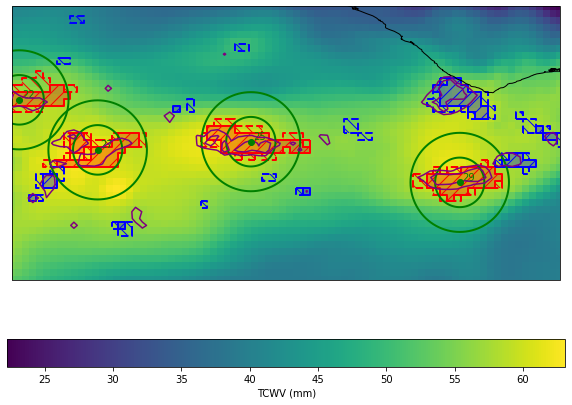

In [4]:
importlib.reload(mcs_mask_plotter)
plotter = mcs_mask_plotter.McsMaskPlotter(pdata)
plotter.plot(None, times[0], 'tcwv', (-25, -5, -2.5, 7.5))
# plotter.plot(times[1], 'cape', (-25, -5, -2.5, 7.5), show_radii=False)
# plotter.plot(times[1], 'tcwv', (-25, -5, -2, 10), show_radii=False)
# plotter.plot(times[1], 'tcwv', (-55, -5, -20, 20), show_radii=False)


In [5]:
plotter.plot(times[1])

AttributeError: 'Timestamp' object has no attribute 'contour'

In [ ]:
importlib.reload(mcs_mask_plotter)
plotter = mcs_mask_plotter.McsMaskPlotter(pdata)
plotter.plot(time=times[6], var='tcwv', extent=(-25, -5, -2.5, 7.5), grid_x=[-20, -15, -10], grid_y=[-2, 0, 2, 4, 6])

In [ ]:
importlib.reload(mcs_mask_plotter)
plotter = mcs_mask_plotter.McsMaskPlotter(pdata)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((18, 8))

plotter.animate(fig, ax, 
    [
        ((t, 'tcwv', (-25, -5, -2.5, 7.5)), {})
        for t in times
    ])

In [ ]:
importlib.reload(mcs_mask_plotter)
plotter = mcs_mask_plotter.McsMaskPlotter(pdata)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((10, 10))

plotter.animate_track(fig, ax, 25)


In [ ]:
importlib.reload(mcs_mask_plotter)
plotter = mcs_mask_plotter.McsMaskPlotter(pdata)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((18, 18))
plotter.plot(ax, *(times[0], 'tcwv', (-25, -5, -2.5, 7.5)), **dict(show_radii=False))


In [ ]:
grm = t.depends_on[-1]
grm

In [ ]:
clmd = t.depends_on[0]

In [ ]:
clmd

In [ ]:
clmd??

In [ ]:
t

In [ ]:
inputs = dict([(k, v) 
          for k, v in t.inputs.items()
          if k[:7] == 'e5pixel'][:20])
inputs['tracks'] = t.inputs['tracks']
          
tracks, e5pixel = clmd(logger, t.year, t.month, inputs)

In [ ]:
e5pixel = e5pixel.isel(time=slice(24))

In [ ]:
mcm, msm, ccm, csm, em = grm(logger, e5pixel, tracks)

In [ ]:
lat = e5pixel.latitude.values
lon = e5pixel.longitude.values
dlat = lat[1] - lat[0]
dlon = lon[1] - lon[0]

lat_bounds = np.linspace(lat[0] - dlat / 2, lat[-1] + dlat / 2, len(lat) + 1)
lon_bounds = np.linspace(lon[0] - dlon / 2, lon[-1] + dlon / 2, len(lon) + 1) % 360

#print(dlat, dlon)
#print(lat_bounds)
#print(lon_bounds)

In [ ]:
def lon_360_to_180(v):
    return np.where(v > 180, v - 360, v)

def create_geoms_from_mask(lon, lat, mask):
    assert len(lon) == mask.shape[1]
    assert len(lat) == mask.shape[0]
    geoms = []
    for yidx, xidx in zip(*np.where(mask)):
        if abs(lon_bounds[xidx] - 180) < 0.5:
            continue
        geoms.append(shapely.geometry.box(
            lon_360_to_180(lon_bounds[xidx]), 
            lat_bounds[yidx], 
            lon_360_to_180(lon_bounds[xidx + 1]), 
            lat_bounds[yidx + 1]
        ))
    full_geom = shapely.ops.unary_union(geoms)
    return full_geom.geoms

In [ ]:
all_geoms = [
    create_geoms_from_mask(e5pixel.longitude, e5pixel.latitude, m[6])
    for m in [mcm, msm, ccm, csm]
]   

In [ ]:
e5pixel.time[6]

In [ ]:
p = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking/20200101.0000_20210101.0000/2020/01/01/mcstrack_20200101_0630.nc')

In [ ]:
p.exists()

In [ ]:
dspixel = xr.open_dataset(p).isel(time=0).load()

In [ ]:
dspixel

In [ ]:
year = 2020
month = 1
day = 1
e5datadir = PATHS['era5dir'] / f'data/oper/an_sfc/{year}/{month:02d}/{day:02d}'

In [ ]:
h = 6

e5time = dt.datetime(year, month, day, h, 0)
paths = [e5datadir / (f'ecmwf-era5_oper_an_sfc_{t.year}{t.month:02d}{t.day:02d}'
                      f'{t.hour:02d}00.{var}.nc')
         for var in ['cape', 'tcwv']
         for t in [e5time, e5time + dt.timedelta(hours=1)]]

In [ ]:
e5data = (xr.open_mfdataset(paths).sel(latitude=slice(60, -60)).mean(dim='time').load())


In [ ]:
s = (slice(210, 251), slice(1340, 1421))
e5data.tcwv[s]

In [ ]:
mcs_time = pd.Timestamp(e5time + dt.timedelta(minutes=30))

In [ ]:
mask = tracks.dstracks.base_time == mcs_time
lats = tracks.dstracks.meanlat.values[mask]
lons = tracks.dstracks.meanlon.values[mask]

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 7.2)
tcwv = e5data.tcwv[s]

# im = ax.contourf(tcwv.longitude, tcwv.latitude, tcwv, levels=np.linspace(0, 70, 15))
lonmin, lonmax = tcwv.longitude.values[[0, -1]] - 360
latmin, latmax = tcwv.latitude.values[[-1, 0]]
print(latmin, latmax)

print(latmin, latmax)
ax.contour(dspixel.longitude, dspixel.latitude, dspixel.precipitation, levels=[2, 5, 10], colors=['purple', 'purple', 'purple'], zorder=5)
im = ax.imshow(tcwv, extent=(lonmin - dlon / 2, lonmax + dlon / 2, latmin + dlat / 2, latmax - dlat / 2), origin='lower')

for geoms, kwargs1, kwargs2 in zip(
    all_geoms,
    [
        dict(facecolor='red', alpha=0.3),
        dict(facecolor='red', alpha=0),
        dict(facecolor='blue', alpha=0.3),
        dict(facecolor='blue', alpha=0),
    ],
    [
        dict(edgecolor='red', linestyle='-', hatch='//'),
        dict(edgecolor='red', linestyle='--', hatch=r'\\'),
        dict(edgecolor='blue', linestyle='-', hatch='//'),
        dict(edgecolor='blue', linestyle='--', hatch=r'\\'),
    ]
):
    # geoms = [g for g in geoms if not filter_geom(g)]
    # geoms = create_geoms_from_mask(e5pixel.longitude, e5pixel.latitude, m[0])
    ax.add_geometries(
        geoms,
        crs=cartopy.crs.PlateCarree(),
        linewidth=0,
        **kwargs1,
    )
    ax.add_geometries(
        geoms,
        crs=cartopy.crs.PlateCarree(),
        facecolor='none',
        linewidth=2,
        **kwargs2,
    )

ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, xlocs=[-20, -15, -10], ylocs=[-2, 0, 2, 4, 6])
#ax.set_xlim((110, 120))
#ax.set_ylim((-10, 0))

plt.colorbar(im, orientation='horizontal', label='TCWV (mm)')
# ax.contour(e5data.longitude, e5data.latitude, e5data.tcwv)

ax.set_xlim((-25, -5))
ax.set_ylim((-2.3, 7.3))
#ax.set_xlim((-10, -5))
#ax.set_ylim((0, 5))
ax.scatter(lons, lats, marker='o', color='g', zorder=10)

geoms = []
for lat, lon in zip(lats, lons):
    if not (lat > -2 and lat < 7 and lon > -25 and lon < 5):
        continue
    for radius in [100, 200]:
        circle_points = cartopy.geodesic.Geodesic().circle(
            lon=lon, lat=lat, radius=radius * 1e3, n_samples=100, endpoint=False
        )
        geom = shapely.geometry.Polygon(circle_points)
        geoms.append(geom)
        
ax.add_geometries(
    geoms,
    crs=cartopy.crs.PlateCarree(),
    facecolor="none",
    edgecolor="g",
    linewidth=2,
)
plt.tight_layout()

In [ ]:
lon[1340], lon[1420], lat[210], lat[250]

In [ ]:
plt.hist(e5data.tcwv[s].values.flatten(), bins=50);

In [ ]:
bins = np.linspace(0, 70, 71)
mids = (bins[1:] + bins[:-1]) / 2
mch = np.histogram(e5data.tcwv.values[s][mcm[6][s]], bins=bins)[0]
msh = np.histogram(e5data.tcwv.values[s][msm[6][s]], bins=bins)[0]
cch = np.histogram(e5data.tcwv.values[s][ccm[6][s]], bins=bins)[0]
csh = np.histogram(e5data.tcwv.values[s][csm[6][s]], bins=bins)[0]
eh = np.histogram(e5data.tcwv.values[s][em[6][s]], bins=bins)[0]

In [ ]:
plt.plot(mids, mch, 'r-')
plt.plot(mids, msh, 'r--')
plt.plot(mids, cch, 'b-')
plt.plot(mids, csh, 'b--')
plt.plot(mids, eh, 'k-')

In [ ]:
for i in range(mcm.shape[0]):
    print(i)
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches((20, 10))                                          
    ax.contour(e5pixel.longitude, e5pixel.latitude, mcm[i], levels=[0.5], colors=['b'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, msm[i], levels=[0.5], colors=['b'], linestyles=['--'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, ccm[i], levels=[0.5], colors=['r'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, csm[i], levels=[0.5], colors=['r'], linestyles=['--'])
    ax.coastlines()

In [ ]:
for i in range(mcm.shape[0]):
    print(i)
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches((10, 10))                                          
    ax.contour(e5pixel.longitude, e5pixel.latitude, mcm[i], levels=[0.5], colors=['b'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, msm[i], levels=[0.5], colors=['b'], linestyles=['--'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, ccm[i], levels=[0.5], colors=['r'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, csm[i], levels=[0.5], colors=['r'], linestyles=['--'])
    ax.coastlines()
    ax.set_xlim((100, 140)),
    ax.set_ylim((-20, 20))

In [ ]:
for i in range(mcm.shape[0]):
    print(i)
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches((10, 10))                                          
    ax.contour(e5pixel.longitude, e5pixel.latitude, mcm[i], levels=[0.5], colors=['b'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, msm[i], levels=[0.5], colors=['b'], linestyles=['--'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, ccm[i], levels=[0.5], colors=['r'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, csm[i], levels=[0.5], colors=['r'], linestyles=['--'])
    ax.coastlines()
    ax.set_xlim((-20, 20)),
    ax.set_ylim((-20, 20))

In [ ]:
for i in range(mcm.shape[0]):
    print(i)
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches((10, 10))                                          
    ax.contour(e5pixel.longitude, e5pixel.latitude, mcm[i], levels=[0.5], colors=['b'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, msm[i], levels=[0.5], colors=['b'], linestyles=['--'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, ccm[i], levels=[0.5], colors=['r'])
    ax.contour(e5pixel.longitude, e5pixel.latitude, csm[i], levels=[0.5], colors=['r'], linestyles=['--'])
    ax.coastlines()
    ax.set_xlim((-20, -10))
    ax.set_ylim((0, 10))

In [ ]:
print(mcm.sum())
print(msm.sum())
print(ccm.sum())
print(csm.sum())
print(em.sum())

In [ ]:
print(mcm.sum() / (ccm.sum() + mcm.sum()))
print(msm.sum() / (csm.sum() + msm.sum()))

In [ ]:
print(mcm.sum() / (mcm.sum() + msm.sum()))
print(ccm.sum() / (ccm.sum() + csm.sum()))

In [ ]:
print(em.sum() / em.size)

In [ ]:
i = 6
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((10, 10))                                          
ax.contour(e5pixel.longitude, e5pixel.latitude, mcm[i], levels=[0.5], colors=['r'])
ax.contour(e5pixel.longitude, e5pixel.latitude, msm[i], levels=[0.5], colors=['r'], linestyles=['--'])
ax.contour(e5pixel.longitude, e5pixel.latitude, ccm[i], levels=[0.5], colors=['b'])
ax.contour(e5pixel.longitude, e5pixel.latitude, csm[i], levels=[0.5], colors=['b'], linestyles=['--'])
ax.coastlines()
ax.set_xlim((100, 140))
ax.set_ylim((-20, 20))